# Imports

In [1]:
# Ajouter chemin système pour naviguer d'un dossier à l'autre facilement
import sys
from pathlib import Path
sys.path.append(str(Path('.').absolute().parent))

In [2]:
########## Imports ##########
!pip install protobuf==3.20.0
import pandas as pd
import numpy as np
import os
from glob import glob
import pickle
from packages import fonctions, data_preparation
import time
import random
import string
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
%matplotlib inline 
# vérifier si vraiment utile

# Pillow
from PIL import Image

# Sift
!pip install cv2
!pip install opencv-python
!pip install opencv-python==3.3.0.10 opencv-contrib-python==3.3.0.10
!pip install opencv-contrib-python
import cv2
from IPython import display

from os import listdir

# Sklearn
from sklearn import cluster, metrics, preprocessing, manifold, decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Tensorflow
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.preprocessing.image import array_to_img, img_to_array, load_img #ImageDataGenerator, 

# Keras
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.utils import load_img, img_to_array, to_categorical

  Using cached protobuf-3.20.0-py2.py3-none-any.whl.metadata (720 bytes)
Using cached protobuf-3.20.0-py2.py3-none-any.whl (162 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery-storage 2.19.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.0 which is incompatible.
google-cloud-bigquery 3.10.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.0 which is incompatible.
grpcio-status 1.54.0 requires protobuf>=4.21.6, but you have protobuf 3.20.0 which is incompatible.
tensorflow-macos 2.13.0 requires keras<2.1

In [3]:
########## Apparence ##########

# Warnings
import warnings
warnings.simplefilter(action = 'ignore')

# Set display preferences
pd.set_option('display.max_row', 250)
pd.set_option('display.max_column', 100)

# Choix d'une palette de couleurs
sns.set_palette('Set2', color_codes = True)
print(sns.color_palette('Set2').as_hex())
sns.set_style('darkgrid')
sns.color_palette()

['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']


[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [4]:
########## Consignes ##########

# Afin d’extraire les features image, il sera nécessaire de mettre en œuvre :
# - un algorithme de type SIFT / ORB / SURF
# - un algorithme de type CNN Transfer Learning.
# Concernant l’approche de type SIFT, je t’invite à regarder le webinaire que nous avons réalisé, disponible dans les ressources

In [5]:
########## Cours ##########

# Une image numérique est caractérisée par sa définition et sa résolution
# Définition = hauteur × largeur (en pixels)
# Résolution = nombre de pixels par unité de longueur de l'image analogique. Elle permet de mesurer la qualité de l'image obtenue après numérisation : plus la résolution est élevée, meilleure est la qualité de l'image

# 1 mégapixel = 1 million de pixels
# -> = définition (donc taille, pas forcément qualité)

In [6]:
########## Formats de fichiers ##########
# -> compression de l'image

# formats de compression sans perte de données -> PNG, TIFF...
# formats de compression avec perte de données -> JPEG

# Préparation des données

In [7]:
########## Import données csv ##########

df = pd.read_csv('../../data/df_clean.csv')

print(f'Dimension des données : {df.shape}')
df.head()

Dimension des données : (924, 18)


uniq_id crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7      2016-04-30   
1  7b72c92c2f6c40268628ec5f14c6d590      2016-04-30   
2  d4684dcdc759dd9cdf41504698d737d8      2016-06-20   
3  6325b6870c54cd47be6ebfbffa620ec7      2016-06-20   
4  f355cc1ccb08bd0d283ed979b7ee7515      2015-12-04   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/santosh-royal-fashion-...   
3  http://www.flipkart.com/jaipur-print-cotton-fl...   
4  http://www.flipkart.com/camerii-wm64-elegance-...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2  SANTOSH ROYAL FASHION Cotton Printed King size...   
3  Jaipur Print Cotton Floral King sized Double B...   
4  Camerii WM64 Elegance Analog Watch  - For Men,...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   
4  ["Watches >> Wrist Watches >> Camerii Wrist Wa...  WATE6Y6D2MZHWGBZ   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
3        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   
4        1099.0             449.0  f355cc1ccb08bd0d283ed979b7ee7515.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
3                    False  Key Features of Jaipur Print Cotton Floral Kin...   
4                    False  Camerii WM64 Elegance Analog Watch  - For Men,...   

        product_rating       overall_rating  \
0  No rating available  No rating available   
1  No rating available  No rating available   
2  No rating available  No rating available   
3  No rating available  No rating available   
4                    5                    5   

                              product_specifications         category  \
0  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing   
1  {"product_specification"=>[{"key"=>"Machine Wa...        Baby Care   
2  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing   
3  {"product_specification"=>[{"key"=>"Machine Wa...  Home Furnishing   
4  {"product_specification"=>[{"key"=>"Chronograp...    Wrist Watches   

                    category_4           sous_category sous_ensemble  
0   Home and Kitchen Essential  Curtains & Accessories      Curtains  
1       Baby and Personal Care        Baby Bath & Skin          Baby  
2   Home and Kitchen Essential               Bed Linen           Bed  
3   Home and Kitchen Essential               Bed Linen           Bed  
4  Electronics and Accessories           Wrist Watches         Wrist

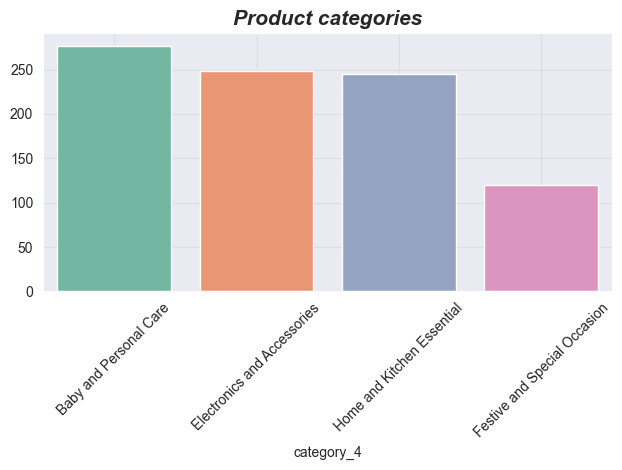

In [8]:
# Barplot des catégories de produits

product_categories = df['category_4'].value_counts()

plt.figure()
sns.barplot(x = product_categories.index, y = product_categories.values)
plt.title('Product categories', fontweight = 'bold', fontstyle = 'italic', fontsize = 15)
plt.xticks(rotation = 45)
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()
plt.tight_layout()
plt.show()

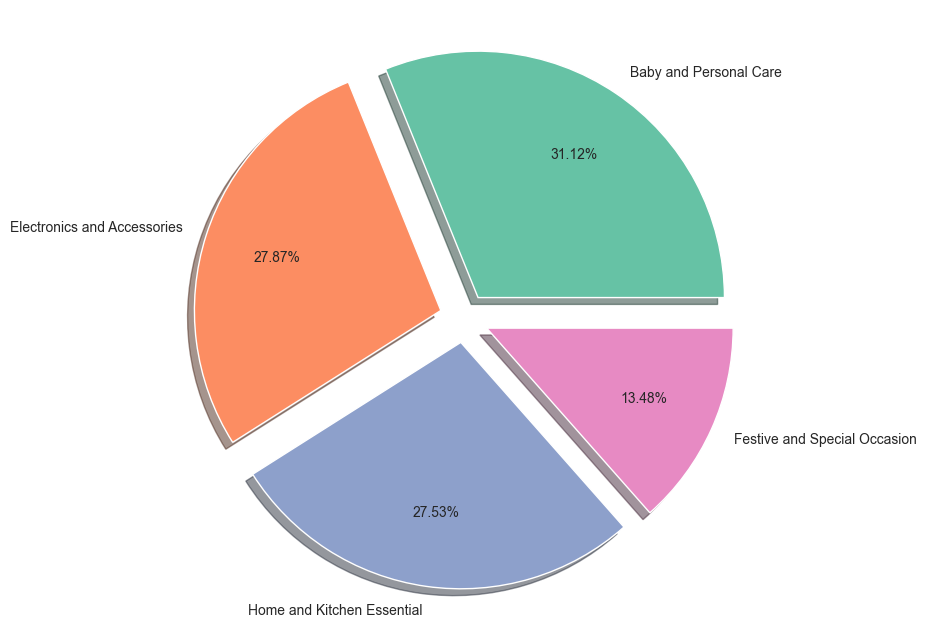

In [9]:
# Même chose mais sous forme de camembert (pie chart)

plt.figure(figsize = (8, 8))
plt.pie(
    x = df['category_4'].value_counts().values,
    labels = df['category_4'].value_counts().index,
    explode = [0.1, 0.1, 0.1, 0.1],
    autopct = lambda x: str(round(x, 2)) + '%',
    pctdistance = 0.7,
    shadow = True
    )
plt.show()

In [10]:
df['category_4'].unique()

array(['Home and Kitchen Essential', 'Baby and Personal Care',
       'Electronics and Accessories', 'Festive and Special Occasion', nan],
      dtype=object)

In [11]:
df.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'product_specifications', 'category', 'category_4',
       'sous_category', 'sous_ensemble'],
      dtype='object')

In [12]:
# Réduire le dataframe pour ne garder que le nom des catégories et le nom des images (on garde le product_category_tree dans un premier temps pour vérification des labels)
data = df[['category_4', 'product_category_tree', 'image']]
data.columns = ['label_name', 'product_category_tree', 'image_name']
data.shape

(924, 3)

In [13]:
data

label_name  \
0     Home and Kitchen Essential   
1         Baby and Personal Care   
2     Home and Kitchen Essential   
3     Home and Kitchen Essential   
4    Electronics and Accessories   
..                           ...   
919       Baby and Personal Care   
920       Baby and Personal Care   
921       Baby and Personal Care   
922       Baby and Personal Care   
923       Baby and Personal Care   

                                 product_category_tree  \
0    ["Home Furnishing >> Curtains & Accessories >>...   
1    ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
2    ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
3    ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
4    ["Watches >> Wrist Watches >> Camerii Wrist Wa...   
..                                                 ...   
919  ["Baby Care >> Baby & Kids Gifts >> Stickers >...   
920  ["Baby Care >> Baby & Kids Gifts >> Stickers >...   
921  ["Baby Care >> Baby & Kids Gifts >> Stickers >...   
922  ["Baby Care >> Baby & Kids Gifts >> Stickers >...   
923  ["Baby Care >> Baby & Kids Gifts >> Stickers >...   

                               image_name  
0    55b85ea15a1536d46b7190ad6fff8ce7.jpg  
1    7b72c92c2f6c40268628ec5f14c6d590.jpg  
2    d4684dcdc759dd9cdf41504698d737d8.jpg  
3    6325b6870c54cd47be6ebfbffa620ec7.jpg  
4    f355cc1ccb08bd0d283ed979b7ee7515.jpg  
..                                    ...  
919  38782cce965307ddcdbedfcb7fa409c3.jpg  
920  be0f39341d771aac57084970f1ed6425.jpg  
921  958f54f4c46b53c8a0a9b8167d9140bc.jpg  
922  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg  
923  f2f027ad6a6df617c9f125173da71e44.jpg  

[924 rows x 3 columns]

In [14]:
data['label_name'].unique().tolist()

['Home and Kitchen Essential',
 'Baby and Personal Care',
 'Electronics and Accessories',
 'Festive and Special Occasion',
 nan]

In [15]:
# Ajout du chemin des images

path = '../../data/Images/'
data['image_path'] = path + data['image_name']

In [16]:
# Encoding des labels

le = preprocessing.LabelEncoder()
le.fit(data['label_name'])
data['label'] = le.transform(data['label_name'])
data.head(5)

label_name  \
0   Home and Kitchen Essential   
1       Baby and Personal Care   
2   Home and Kitchen Essential   
3   Home and Kitchen Essential   
4  Electronics and Accessories   

                               product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >>...   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
2  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
4  ["Watches >> Wrist Watches >> Camerii Wrist Wa...   

                             image_name  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  d4684dcdc759dd9cdf41504698d737d8.jpg   
3  6325b6870c54cd47be6ebfbffa620ec7.jpg   
4  f355cc1ccb08bd0d283ed979b7ee7515.jpg   

                                          image_path  label  
0  ../../data/Images/55b85ea15a1536d46b7190ad6fff...      3  
1  ../../data/Images/7b72c92c2f6c40268628ec5f14c6...      0  
2  ../../data/Images/d4684dcdc759dd9cdf41504698d7...      3  
3  ../../data/Images/6325b6870c54cd47be6ebfbffa62...      3  
4  ../../data/Images/f355cc1ccb08bd0d283ed979b7ee...      1

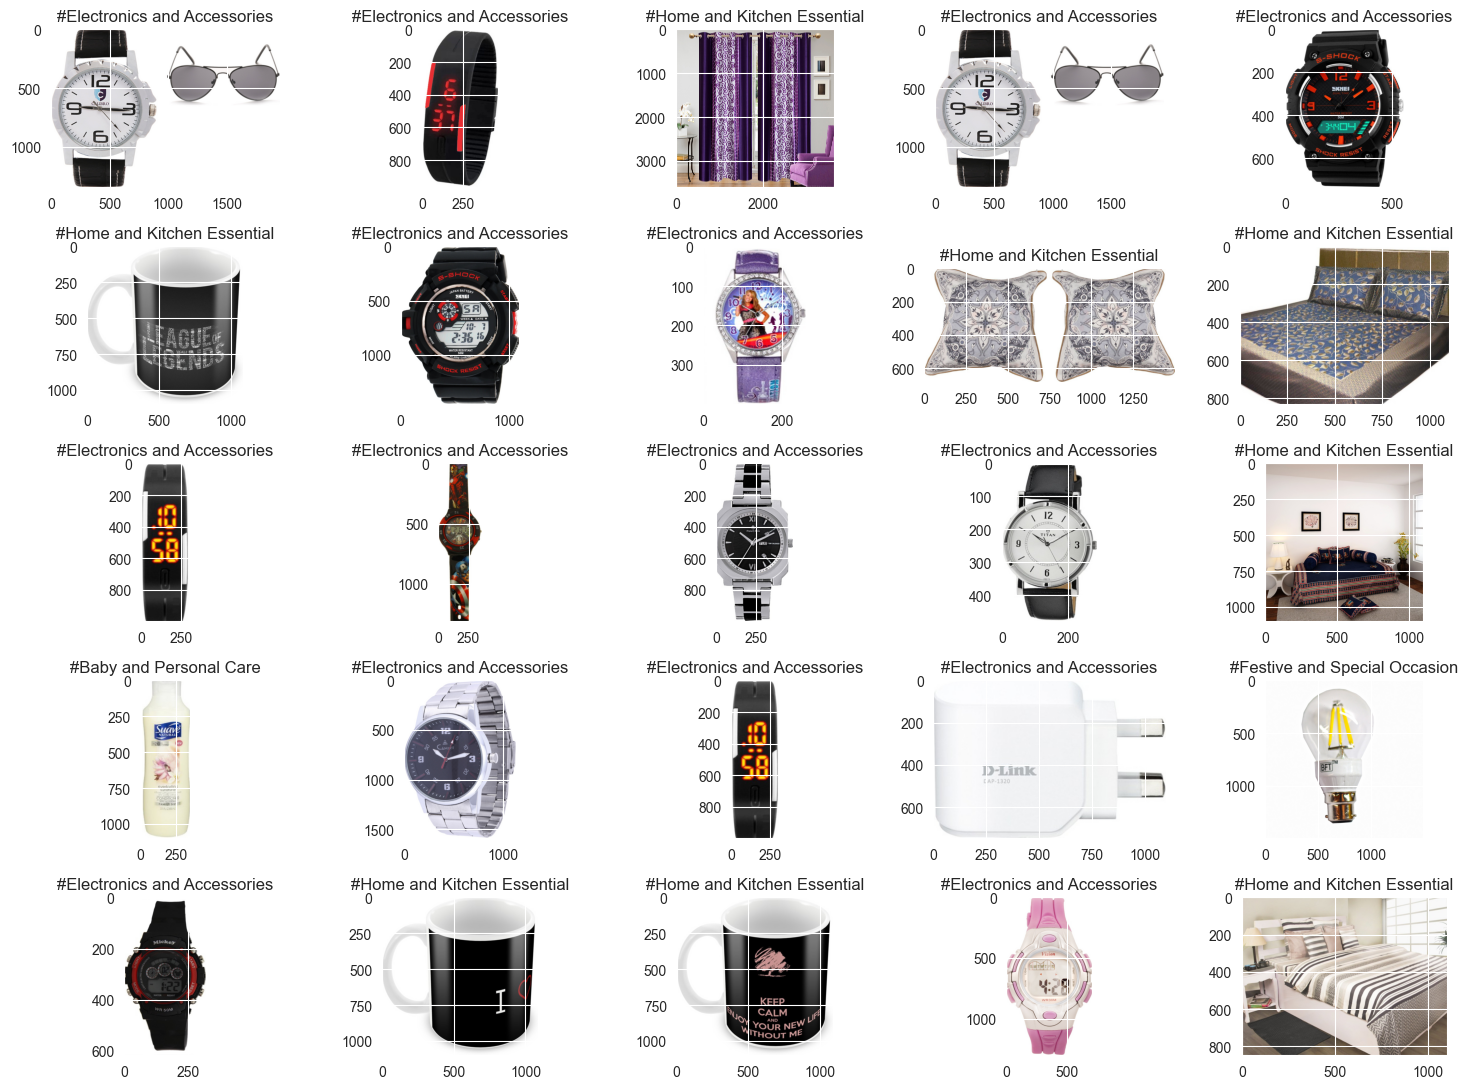

In [17]:
# plot 25 images au hasard

plt.figure(figsize = (15, 11))

for i in range(0, 25):
    plt.subplot(5, 5, 1 + i)
    x = int(np.random.randint(0, 44, 1))
    image = imread(data['image_path'][x])
    plt.title(f"#{data['label_name'][x]}")
    plt.imshow(image)

plt.tight_layout()
plt.show()

In [18]:
# créer une copie pour plus tard
df_image = data.copy()

# Supprimer colonne image de data
data.drop(['image_name', 'product_category_tree'], axis = 1, inplace = True)

In [19]:
# Nombre d'images par catégorie
data.groupby('label').count()

label_name  image_path
label                        
0             277         277
1             248         248
2             120         120
3             245         245
4               0          34

In [20]:
########## Gestion des données manquantes ##########
# quelques images non catégorisées -> données manquantes
# Isolation des données manquantes dans un df à part pour traitement ultérieur
df_nan = data.loc[data['label_name'].isna()]
df_nan

label_name                                         image_path  label
44         NaN  ../../data/Images/f01140c02fd09e5c56312a64fa8d...      4
78         NaN  ../../data/Images/0096e89cc25a8b96fb9808716406...      4
201        NaN  ../../data/Images/ed139e0d1b5c973495e1aa35dd4a...      4
204        NaN  ../../data/Images/2e8df36b35d22cf219cf8bae6c2a...      4
206        NaN  ../../data/Images/7e4c1d31e279a700c6b8e66d820e...      4
207        NaN  ../../data/Images/1357e9d24661c3b5797aa1016e0c...      4
208        NaN  ../../data/Images/799ddb97164ff2d5d53bb8b27b8c...      4
209        NaN  ../../data/Images/607dc41467008ee7a8dba0276f18...      4
210        NaN  ../../data/Images/0c4718ae90f2889b7021a99ee1cc...      4
211        NaN  ../../data/Images/85fe188e1ee8237b70df0d475907...      4
212        NaN  ../../data/Images/ea42376c9c52752d9d01bba12eb2...      4
213        NaN  ../../data/Images/87f1807e002d3555b8dfb465a8a6...      4
214        NaN  ../../data/Images/0131e5d87b72877702d536299cf8...      4
216        NaN  ../../data/Images/72cbc043d14ee578c789c9fab3c4...      4
217        NaN  ../../data/Images/6bc04b3ec1f8d4da2a00f8662f4f...      4
218        NaN  ../../data/Images/fb733e04ff2d72c59d8513eb574e...      4
220        NaN  ../../data/Images/c38eb8abdaa1d8c28bc8c262761d...      4
224        NaN  ../../data/Images/724e6eb7edc83eb48b6492d12e94...      4
226        NaN  ../../data/Images/273982a65b9c7dabe56c8345552b...      4
231        NaN  ../../data/Images/0e73201f6d8807776e1d21c96907...      4
232        NaN  ../../data/Images/86dcb7d4ce6ec7bfb3e26d1bd859...      4
237        NaN  ../../data/Images/6a1afb657e9ac01e3ca1956dfdcc...      4
238        NaN  ../../data/Images/c3e1435782c0929327449eec1147...      4
261        NaN  ../../data/Images/8c6942026d53b881d1da9359ea19...      4
382        NaN  ../../data/Images/7cb1ea7b2257aeeeba701a8f6e3e...      4
383        NaN  ../../data/Images/3b0f02b3acf1825f8bbc1fb3b860...      4
522        NaN  ../../data/Images/baa093d149982b010ab72ecbeec6...      4
574        NaN  ../../data/Images/3f025b9dc8065fe5a155573e5b21...      4
577        NaN  ../../data/Images/0ca8e323551dd7107ef57ef7c3e7...      4
579        NaN  ../../data/Images/c997312abfa36281d41366cb4a3b...      4
583        NaN  ../../data/Images/5518124b75d6c6dfee4c2e4c0cfa...      4
586        NaN  ../../data/Images/025a85a3d1cddc6307f7dc075d8d...      4
595        NaN  ../../data/Images/55195de3873fffaa9e37b041533d...      4
642        NaN  ../../data/Images/52877a6306aef18af67ab54c8233...      4

In [21]:
df_nan.reset_index(drop = True, inplace = True)

In [22]:
df_nan.shape

(34, 3)

In [23]:
# lister les images 'nan':
liste_images_nan = df_nan['image_path'].to_list()
liste_images_nan

['../../data/Images/f01140c02fd09e5c56312a64fa8db3da.jpg',
 '../../data/Images/0096e89cc25a8b96fb9808716406fe94.jpg',
 '../../data/Images/ed139e0d1b5c973495e1aa35dd4a5533.jpg',
 '../../data/Images/2e8df36b35d22cf219cf8bae6c2af752.jpg',
 '../../data/Images/7e4c1d31e279a700c6b8e66d820e8601.jpg',
 '../../data/Images/1357e9d24661c3b5797aa1016e0c3be1.jpg',
 '../../data/Images/799ddb97164ff2d5d53bb8b27b8c355f.jpg',
 '../../data/Images/607dc41467008ee7a8dba0276f180f63.jpg',
 '../../data/Images/0c4718ae90f2889b7021a99ee1cc106c.jpg',
 '../../data/Images/85fe188e1ee8237b70df0d475907bf24.jpg',
 '../../data/Images/ea42376c9c52752d9d01bba12eb2999b.jpg',
 '../../data/Images/87f1807e002d3555b8dfb465a8a61df2.jpg',
 '../../data/Images/0131e5d87b72877702d536299cf83b75.jpg',
 '../../data/Images/72cbc043d14ee578c789c9fab3c43cdd.jpg',
 '../../data/Images/6bc04b3ec1f8d4da2a00f8662f4fbed3.jpg',
 '../../data/Images/fb733e04ff2d72c59d8513eb574e81a2.jpg',
 '../../data/Images/c38eb8abdaa1d8c28bc8c262761dfbc5.jpg

KeyError: 34

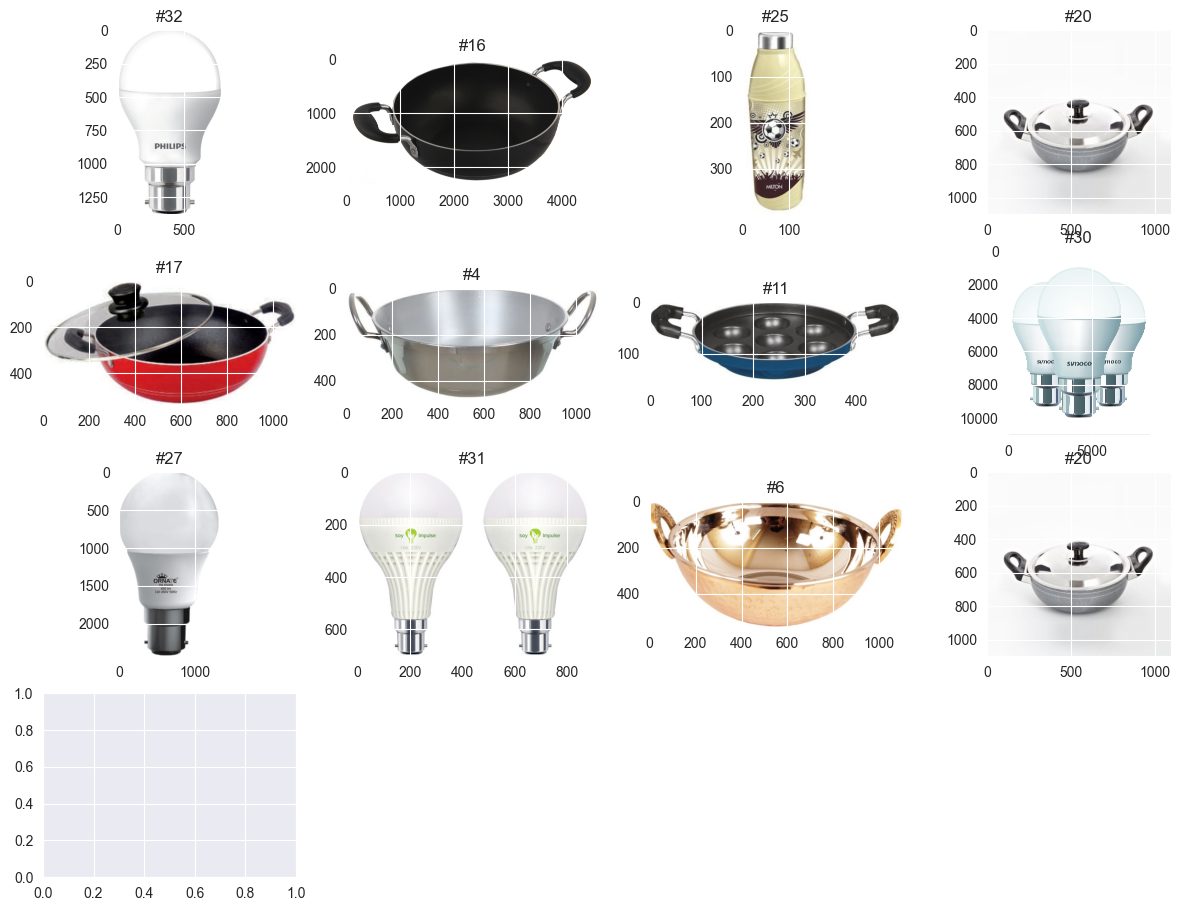

In [24]:
# Visualiser quelques images non catégorisées :

# plot 25 images au hasard
plt.figure(figsize = (15, 11))

for i in range(0, 16):
    plt.subplot(4, 4, 1 + i)
    x = int(np.random.randint(0, 35, 1))
    image = imread(df_nan['image_path'][x])
    plt.title(f'#{x}')
    plt.imshow(image)

plt.tight_layout()
plt.show()

In [ ]:
# enlever le chemin pour ne garder que le nom des images
liste_images_nan = [char.replace('../../data/Images/', '') for char in liste_images_nan]
liste_images_nan

['f01140c02fd09e5c56312a64fa8db3da.jpg',
 '0096e89cc25a8b96fb9808716406fe94.jpg',
 'ed139e0d1b5c973495e1aa35dd4a5533.jpg',
 '2e8df36b35d22cf219cf8bae6c2af752.jpg',
 '7e4c1d31e279a700c6b8e66d820e8601.jpg',
 '1357e9d24661c3b5797aa1016e0c3be1.jpg',
 '799ddb97164ff2d5d53bb8b27b8c355f.jpg',
 '607dc41467008ee7a8dba0276f180f63.jpg',
 '0c4718ae90f2889b7021a99ee1cc106c.jpg',
 '85fe188e1ee8237b70df0d475907bf24.jpg',
 'ea42376c9c52752d9d01bba12eb2999b.jpg',
 '87f1807e002d3555b8dfb465a8a61df2.jpg',
 '0131e5d87b72877702d536299cf83b75.jpg',
 '72cbc043d14ee578c789c9fab3c43cdd.jpg',
 '6bc04b3ec1f8d4da2a00f8662f4fbed3.jpg',
 'fb733e04ff2d72c59d8513eb574e81a2.jpg',
 'c38eb8abdaa1d8c28bc8c262761dfbc5.jpg',
 '724e6eb7edc83eb48b6492d12e940ebd.jpg',
 '273982a65b9c7dabe56c8345552bfad7.jpg',
 '0e73201f6d8807776e1d21c969078289.jpg',
 '86dcb7d4ce6ec7bfb3e26d1bd859f4fb.jpg',
 '6a1afb657e9ac01e3ca1956dfdcc3e9a.jpg',
 'c3e1435782c0929327449eec11475b96.jpg',
 '8c6942026d53b881d1da9359ea19c9fc.jpg',
 '0b8c4bc35aee94

In [ ]:
# on copie le duplique le dossier contenant les images et on en supprime les images qui n'ont pas de catégories ('nan') afin d'avoir au final un dossier avec l'ensemble des images (1050 images) et un dossier ne contenant que les images catégorisées (XXXXX images)

# supprimer les images dont les catégories sont manquantes:

path = '/Users/lucilerabeau/code/LucileRb/classification_auto_consommation/data/Images_sans_nan'
for nan in liste_images_nan:
    if os.path.isfile(nan):
        print('nan')
        #os.remove(nan)

# move plutôt que remove ?

In [ ]:
# deux solutions :
# - 1) labelliser manuellement les images
# - 2) les exclures de l'analyse et le reprendre à la fin pour tester algo de classification

# choix de la 2ème option et drop nan ici
data.dropna(inplace = True)

In [ ]:
# Vérifier que les données ont bien été supprimées
data.loc[data['label_name'].isna()]

Empty DataFrame
Columns: [label_name, image_path, label]
Index: []

In [ ]:
# Re-initialisation de l'index après suppression des données manquantes
data.reset_index(drop = True, inplace = True)

In [ ]:
data

label_name  \
0     Home and Kitchen Essential   
1         Baby and Personal Care   
2     Home and Kitchen Essential   
3     Home and Kitchen Essential   
4    Electronics and Accessories   
..                           ...   
896       Baby and Personal Care   
897       Baby and Personal Care   
898       Baby and Personal Care   
899       Baby and Personal Care   
900       Baby and Personal Care   

                                            image_path  label  
0    ../../data/Images/55b85ea15a1536d46b7190ad6fff...      3  
1    ../../data/Images/7b72c92c2f6c40268628ec5f14c6...      0  
2    ../../data/Images/d4684dcdc759dd9cdf41504698d7...      3  
3    ../../data/Images/6325b6870c54cd47be6ebfbffa62...      3  
4    ../../data/Images/f355cc1ccb08bd0d283ed979b7ee...      1  
..                                                 ...    ...  
896  ../../data/Images/38782cce965307ddcdbedfcb7fa4...      0  
897  ../../data/Images/be0f39341d771aac57084970f1ed...      0  
898  ../../data/Images/958f54f4c46b53c8a0a9b8167d91...      0  
899  ../../data/Images/c3edc504d1b4f0ba6224fa53a43a...      0  
900  ../../data/Images/f2f027ad6a6df617c9f125173da7...      0  

[901 rows x 3 columns]

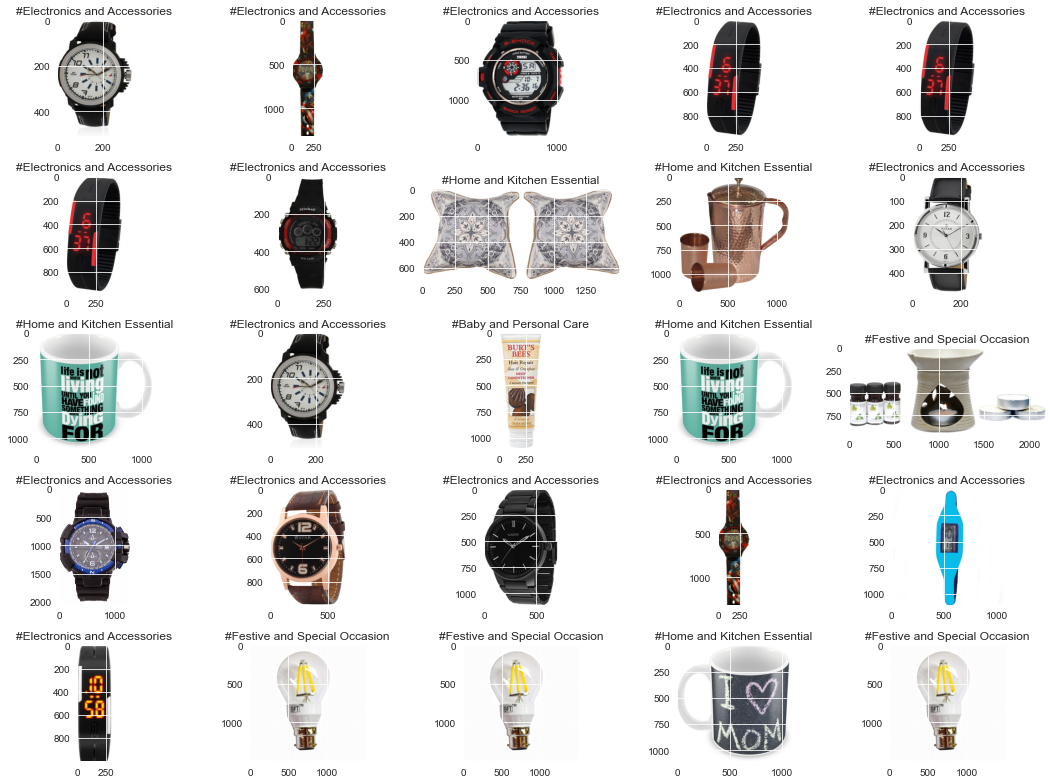

In [ ]:
# plot 25 images au hasard
plt.figure(figsize = (15, 11))

for i in range(0, 25):
    plt.subplot(5, 5, 1 + i)
    x = int(np.random.randint(0, 44, 1))
    image = imread(data['image_path'][x])
    plt.title(f"#{data['label_name'][x]}")
    plt.imshow(image)

plt.tight_layout()
plt.show()

In [ ]:
data.loc[data['label_name'] == 'Electronics and Accessories']

label_name  \
4    Electronics and Accessories   
5    Electronics and Accessories   
6    Electronics and Accessories   
7    Electronics and Accessories   
8    Electronics and Accessories   
..                           ...   
882  Electronics and Accessories   
885  Electronics and Accessories   
887  Electronics and Accessories   
888  Electronics and Accessories   
889  Electronics and Accessories   

                                            image_path  label  
4    ../../data/Images/f355cc1ccb08bd0d283ed979b7ee...      1  
5    ../../data/Images/dd0e3470a7e6ed76fd69c2da2772...      1  
6    ../../data/Images/920154acbe49d3202ed7d2ed2df1...      1  
7    ../../data/Images/1e8741b5ae27a513546c94b3f331...      1  
8    ../../data/Images/189fa66a5fa6f08d2802a62ecf0b...      1  
..                                                 ...    ...  
882  ../../data/Images/9b805665a791f40e7946a73dcea1...      1  
885  ../../data/Images/b5834f1e97c74d2833dbcb09a3f2...      1  
887  ../../data/Images/7815fb39feb773db944c9f03bbdc...      1  
888  ../../data/Images/d407ab825e1a266635214bfe893f...      1  
889  ../../data/Images/5a54c78b52c984e56500809e5bc2...      1  

[254 rows x 3 columns]

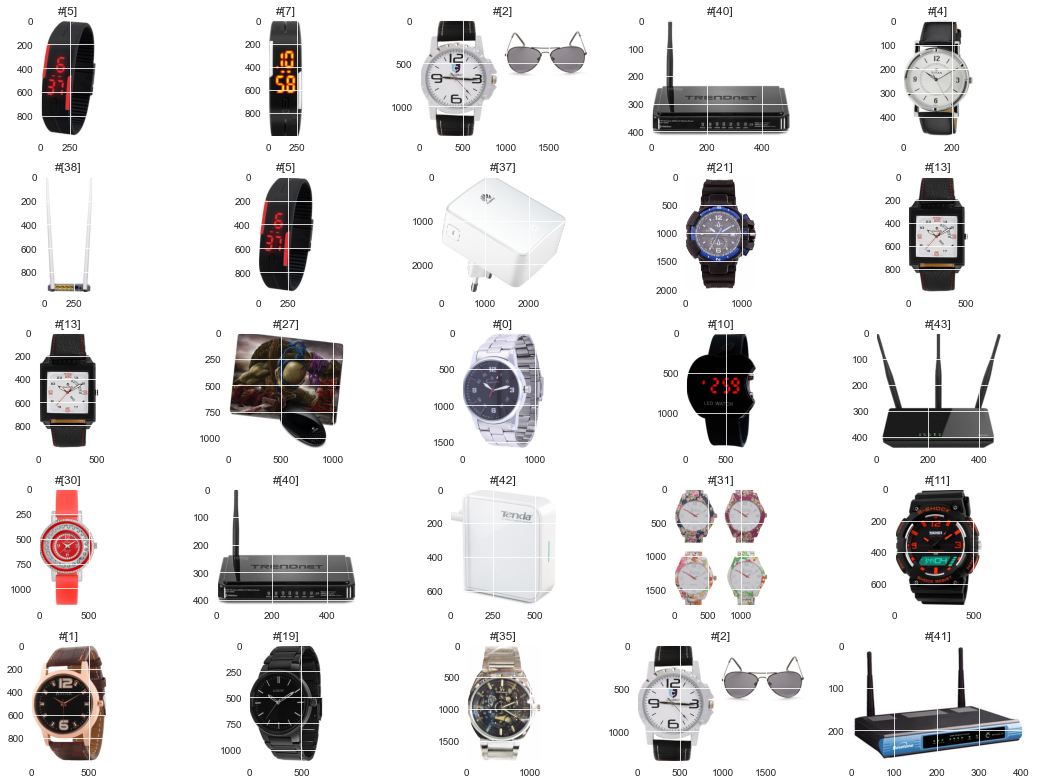

In [ ]:
# plot 25 images au catégorie electronics

data_elec = data.loc[data['label_name'] == 'Electronics and Accessories']
data_elec.reset_index(drop = True, inplace = True)

plt.figure(figsize = (15, 11))

for i in range(0, 25):
    plt.subplot(5, 5, 1 + i)
    x = int(np.random.randint(0, 44, 1))
    image = imread(data_elec['image_path'][x])
    plt.title(f"#{[x]}")
    plt.imshow(image)

plt.tight_layout()
plt.show()

Home and Kitchen Essential


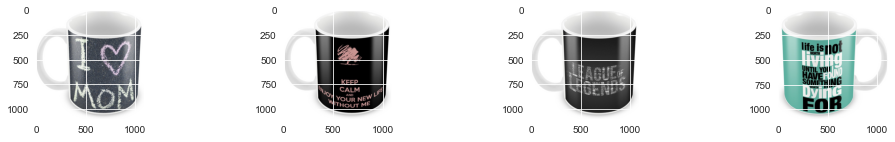

Baby and Personal Care


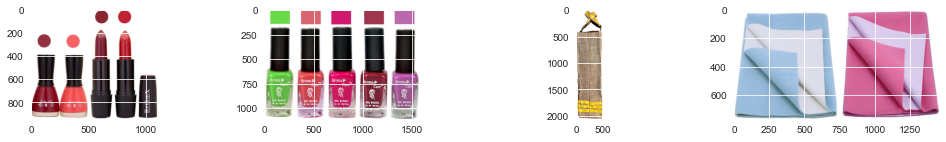

Electronics and Accessories


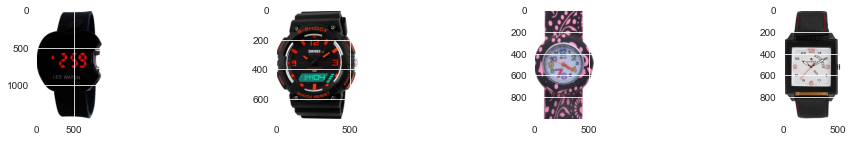

Festive and Special Occasion


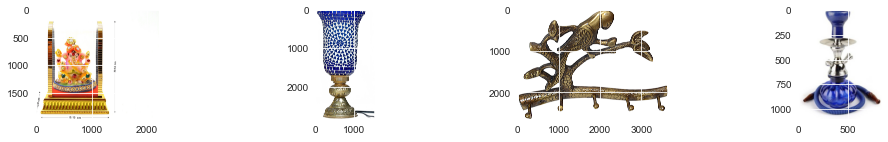

In [ ]:
# Visualisation des images de chaque catégorie
list_labels = data['label_name'].unique().tolist()

for name in list_labels:
    print(name)
    plt.figure(figsize = (17, 2))
    for i in range(len(list_labels)):
        plt.subplot(140 + 1 + i)
        filename = data_preparation.list_fct(data, name)[i + 10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

In [ ]:
# test avec librairie Pillow

# Charger l'image
img = Image.open('../../data/Images/009099b1f6e1e8f893ec29a7023153c4.jpg')

# Afficher l'image chargée dans une autre fenêtre
img.show()

# -> va ouvrir l'image dans une autre fenêtre

In [ ]:
# Récupérer et afficher la taille de l'image en pixels

w, h = img.size
print('Largeur : {} px, hauteur : {} px'.format(w, h))

# Afficher son mode de quantification
print('Format des pixels : {}'.format(img.mode))

# Récupérer et afficher la valeur du pixel à une position précise
px_value = img.getpixel((20, 100))
print('Valeur du pixel situé en (20, 100) : {}'.format(px_value))

Largeur : 687 px, hauteur : 1162 px
Format des pixels : RGB
Valeur du pixel situé en (20, 100) : (255, 255, 255)


In [ ]:
# Récupérer les valeurs de tous les pixels sous forme d'une matrice
mat = np.array(img)

# Afficher la taille de la matrice de pixels
print('Taille de la matrice de pixels : {}'.format(mat.shape))

Taille de la matrice de pixels : (1162, 687, 3)


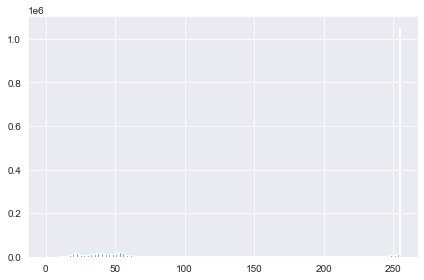

In [ ]:
##### Histogramme #####

# Charger l'image comme matrice de pixels
img = np.array(Image.open('../../data/Images/009099b1f6e1e8f893ec29a7023153c4.jpg'))

# Générer et afficher l'histogramme
# Pour le normaliser : argument density=True dans plt.hist
# Pour avoir l'histogramme cumulé : argument cumulative=True
n, bins, patches = plt.hist(img.flatten(), bins = range(256))
plt.tight_layout()
plt.show()

In [ ]:
# note -> lien "documentation" du cours -> erreur 404
# voir cours -> transformation d'images, extraction de features (bords, etc...)

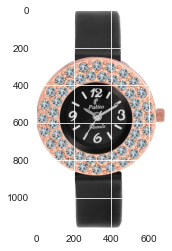

In [ ]:
# define filepath
filepath = '../../data/Images/009099b1f6e1e8f893ec29a7023153c4.jpg'

# load image pixels
image = imread(filepath)

# plot raw pixel data
plt.imshow(image)

In [ ]:
data

label_name  \
0     Home and Kitchen Essential   
1         Baby and Personal Care   
2     Home and Kitchen Essential   
3     Home and Kitchen Essential   
4    Electronics and Accessories   
..                           ...   
896       Baby and Personal Care   
897       Baby and Personal Care   
898       Baby and Personal Care   
899       Baby and Personal Care   
900       Baby and Personal Care   

                                            image_path  label  
0    ../../data/Images/55b85ea15a1536d46b7190ad6fff...      3  
1    ../../data/Images/7b72c92c2f6c40268628ec5f14c6...      0  
2    ../../data/Images/d4684dcdc759dd9cdf41504698d7...      3  
3    ../../data/Images/6325b6870c54cd47be6ebfbffa62...      3  
4    ../../data/Images/f355cc1ccb08bd0d283ed979b7ee...      1  
..                                                 ...    ...  
896  ../../data/Images/38782cce965307ddcdbedfcb7fa4...      0  
897  ../../data/Images/be0f39341d771aac57084970f1ed...      0  
898  ../../data/Images/958f54f4c46b53c8a0a9b8167d91...      0  
899  ../../data/Images/c3edc504d1b4f0ba6224fa53a43a...      0  
900  ../../data/Images/f2f027ad6a6df617c9f125173da7...      0  

[901 rows x 3 columns]

In [ ]:
data.shape

(901, 3)

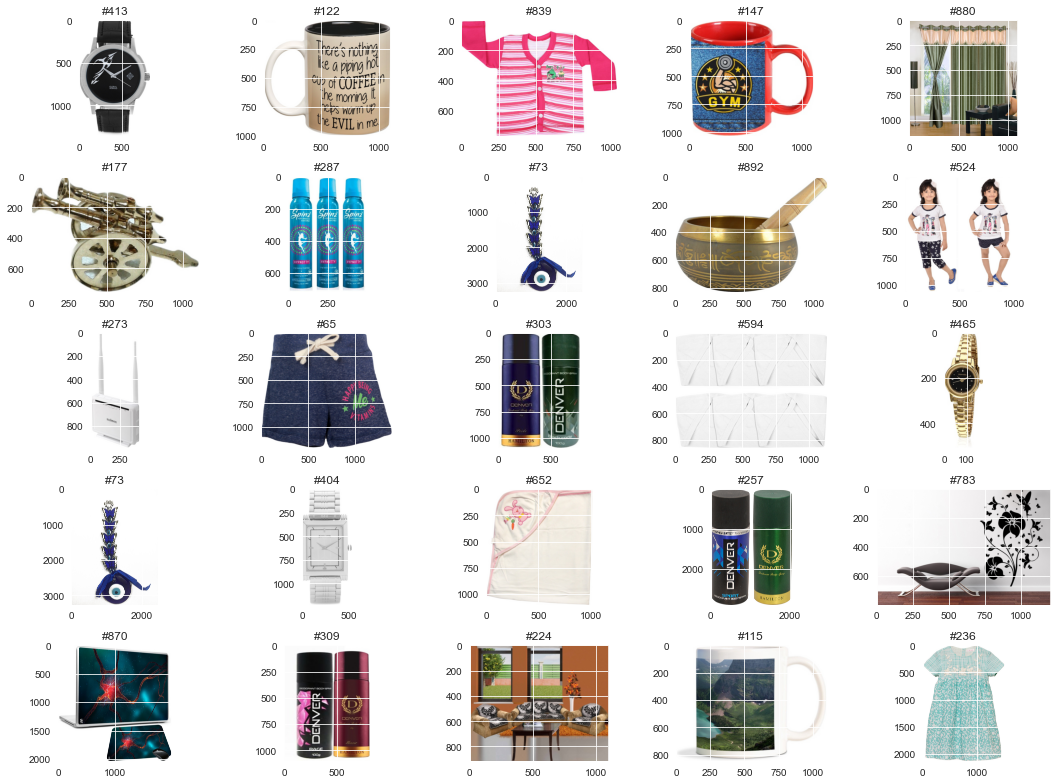

In [ ]:
# plot 25 images au hasard
plt.figure(figsize = (15, 11))

for i in range(0, 25):
    plt.subplot(5, 5, 1 + i)
    x = int(np.random.randint(0, data.shape[0], 1))
    image = imread(data['image_path'][x])
    plt.title(f'#{x}')
    plt.imshow(image)

plt.tight_layout()
plt.show()

In [ ]:
### SIFT

########## Algorithme SIFT #########

# = Scale-invariant feature transform
# méthode permettant d'extraire des features (ou points d'intérêt) de l'image et de calculer leurs descripteurs.

# descripteur = vecteur qui décrit le voisinage de la feature à laquelle il est associé. Il est utilisé pour repérer les paires de features qui se ressemblent le plus dans deux images

# L'algorithme SIFT se divise en plusieurs étapes :
# - Détection : création de l'espace des échelles, calcul des "DoG", localisation des points d'intérêt
# - Description : assignation d'orientation, création des descripteurs


# https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html

# TO DO -> regarder le webinaire

In [ ]:
# SIFT is a patented algorithm, hence not available in each open-cv version -> install opencv and its contrib part simultaneously

In [ ]:
img = cv2.imread('../../data/Images/009099b1f6e1e8f893ec29a7023153c4.jpg')
gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
kp = sift.detect(gray, None)
img = cv2.drawKeypoints(gray, kp, img)
cv2.imwrite('sift_keypoints.jpg', img)

True

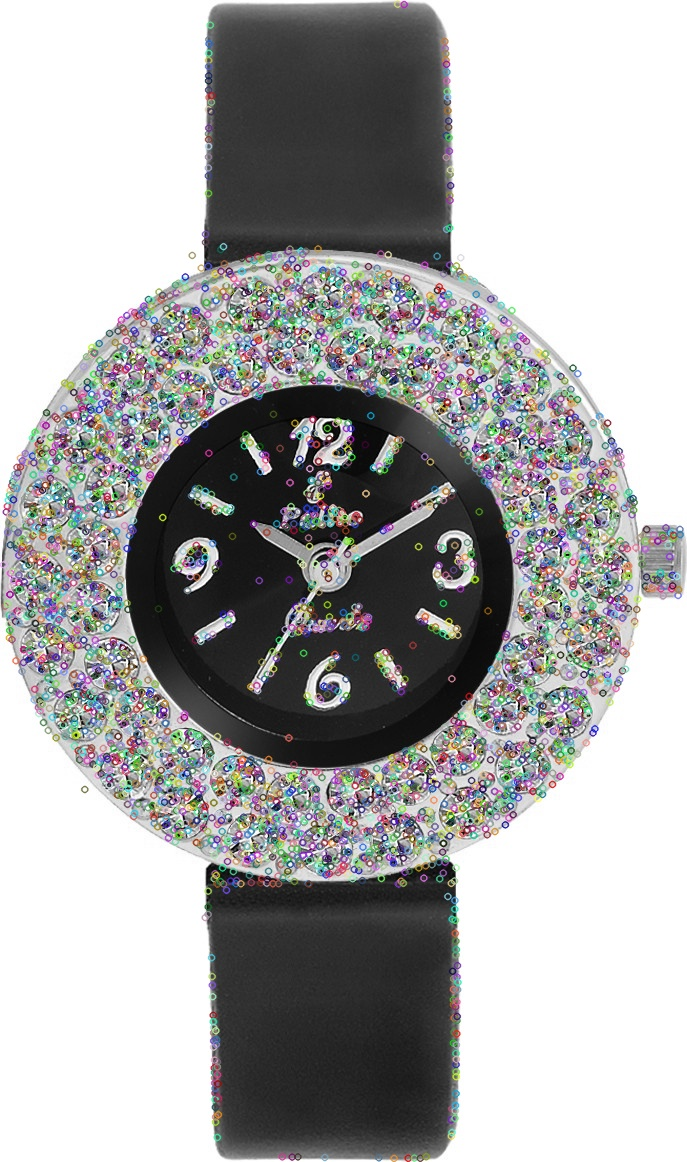

In [ ]:
display.Image("sift_keypoints.jpg", width = 300)

In [ ]:
img = cv2.drawKeypoints(gray, kp, img, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imwrite('sift_keypoints2.jpg', img)

True

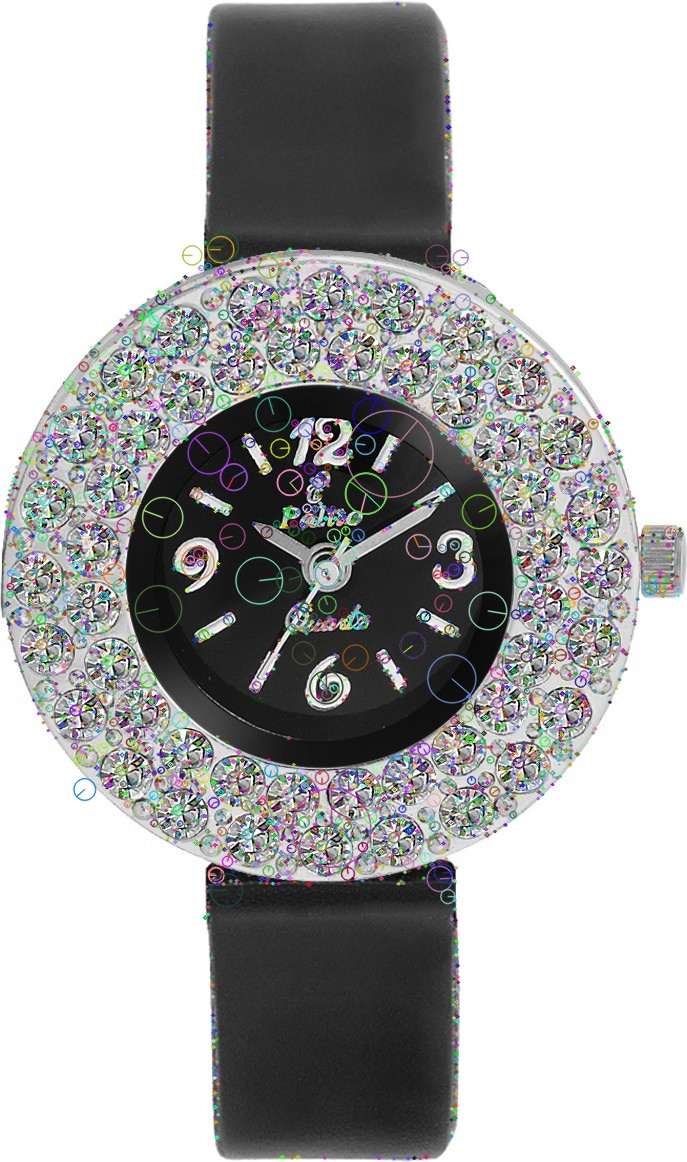

In [ ]:
display.Image("sift_keypoints2.jpg", width = 300)

In [ ]:
sift = cv2.SIFT_create()
kp, des = sift.detectAndCompute(gray, None)

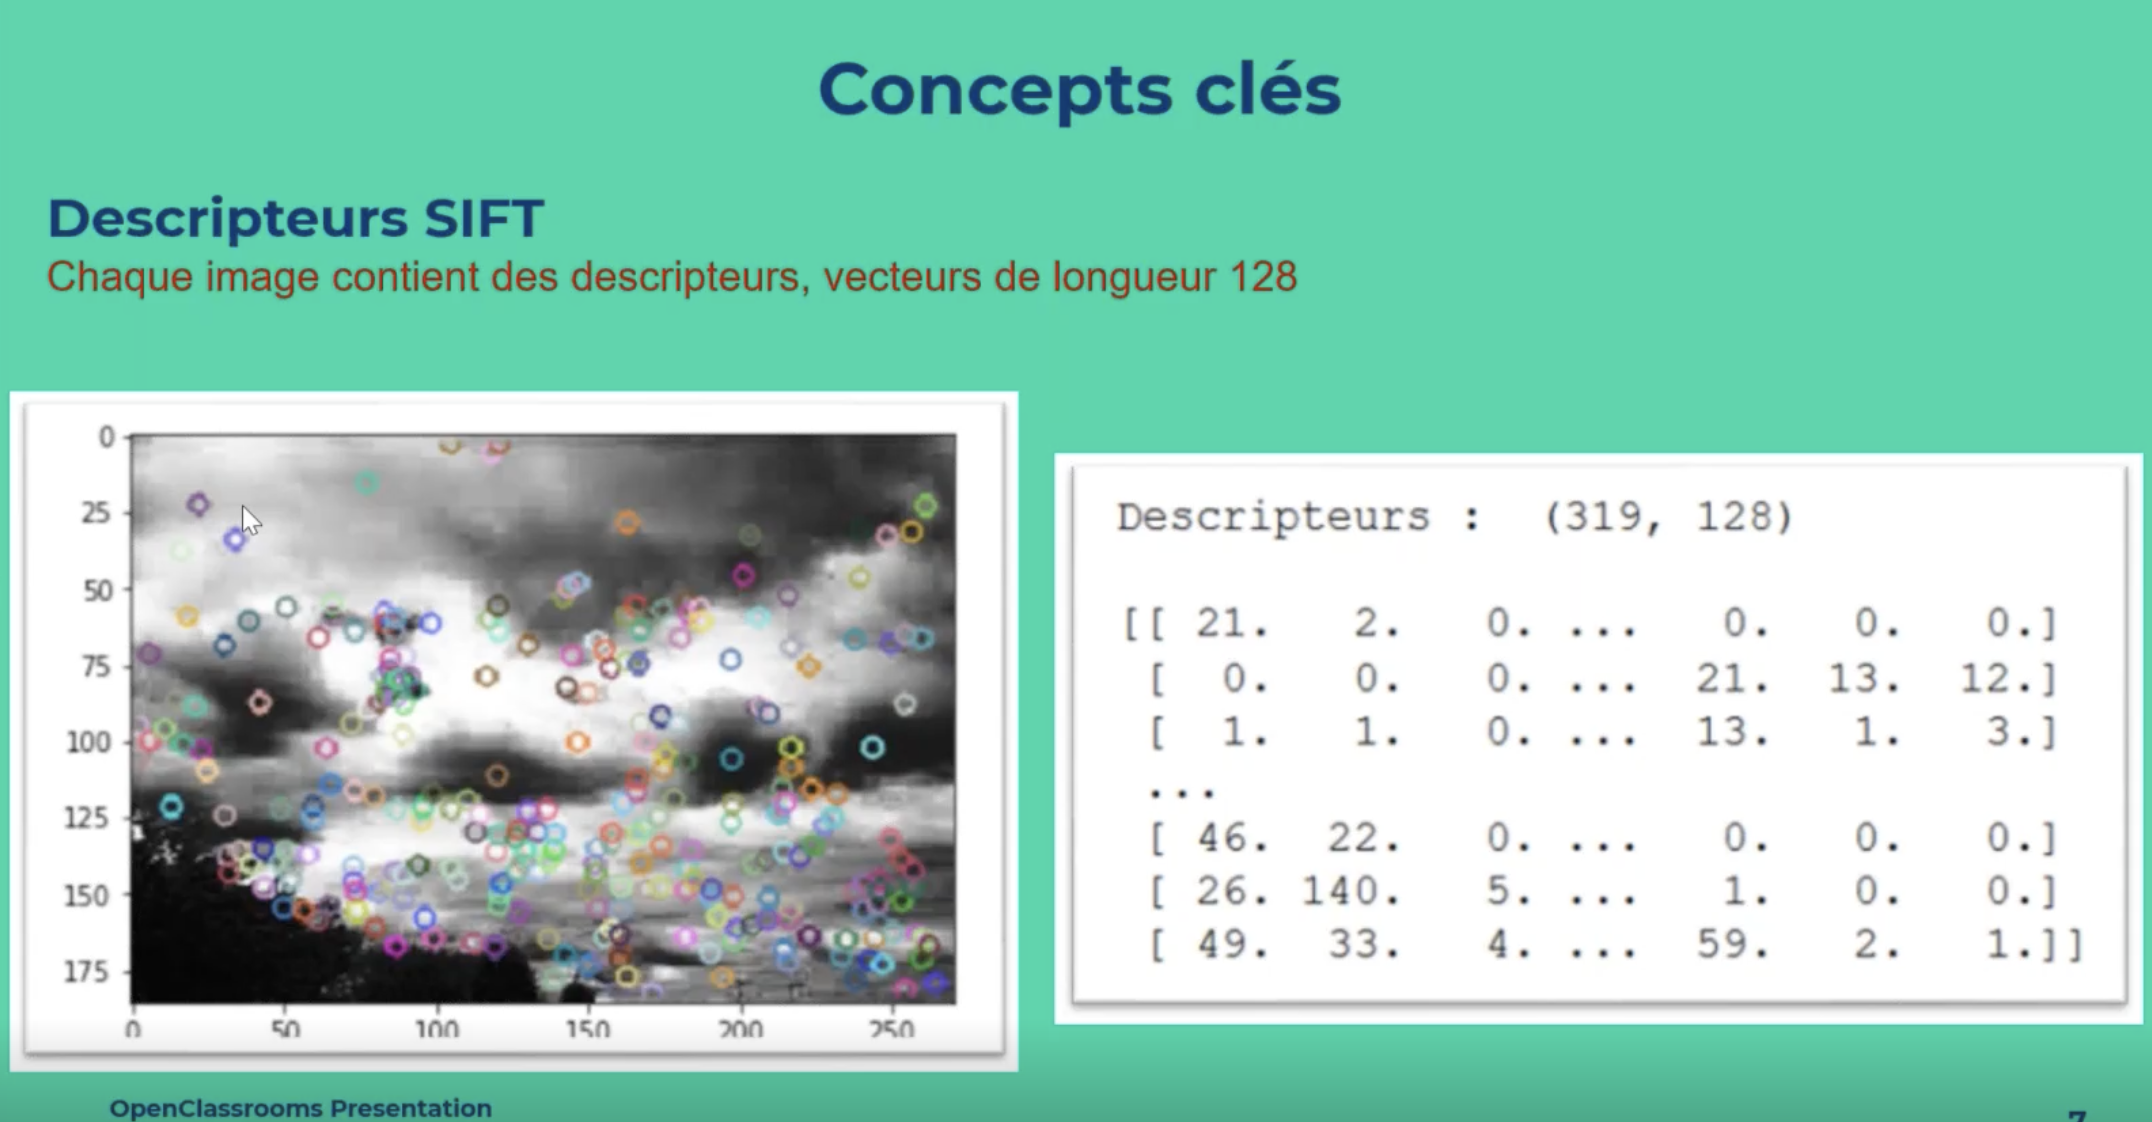

In [ ]:
########## cf code webinar ##########
display.Image("Capture d’écran 2024-01-30 à 13.42.56.png", width = 600)

In [ ]:
# petits ronds -> features (descripteurs)
# ici 319 descripteurs pour une seule image

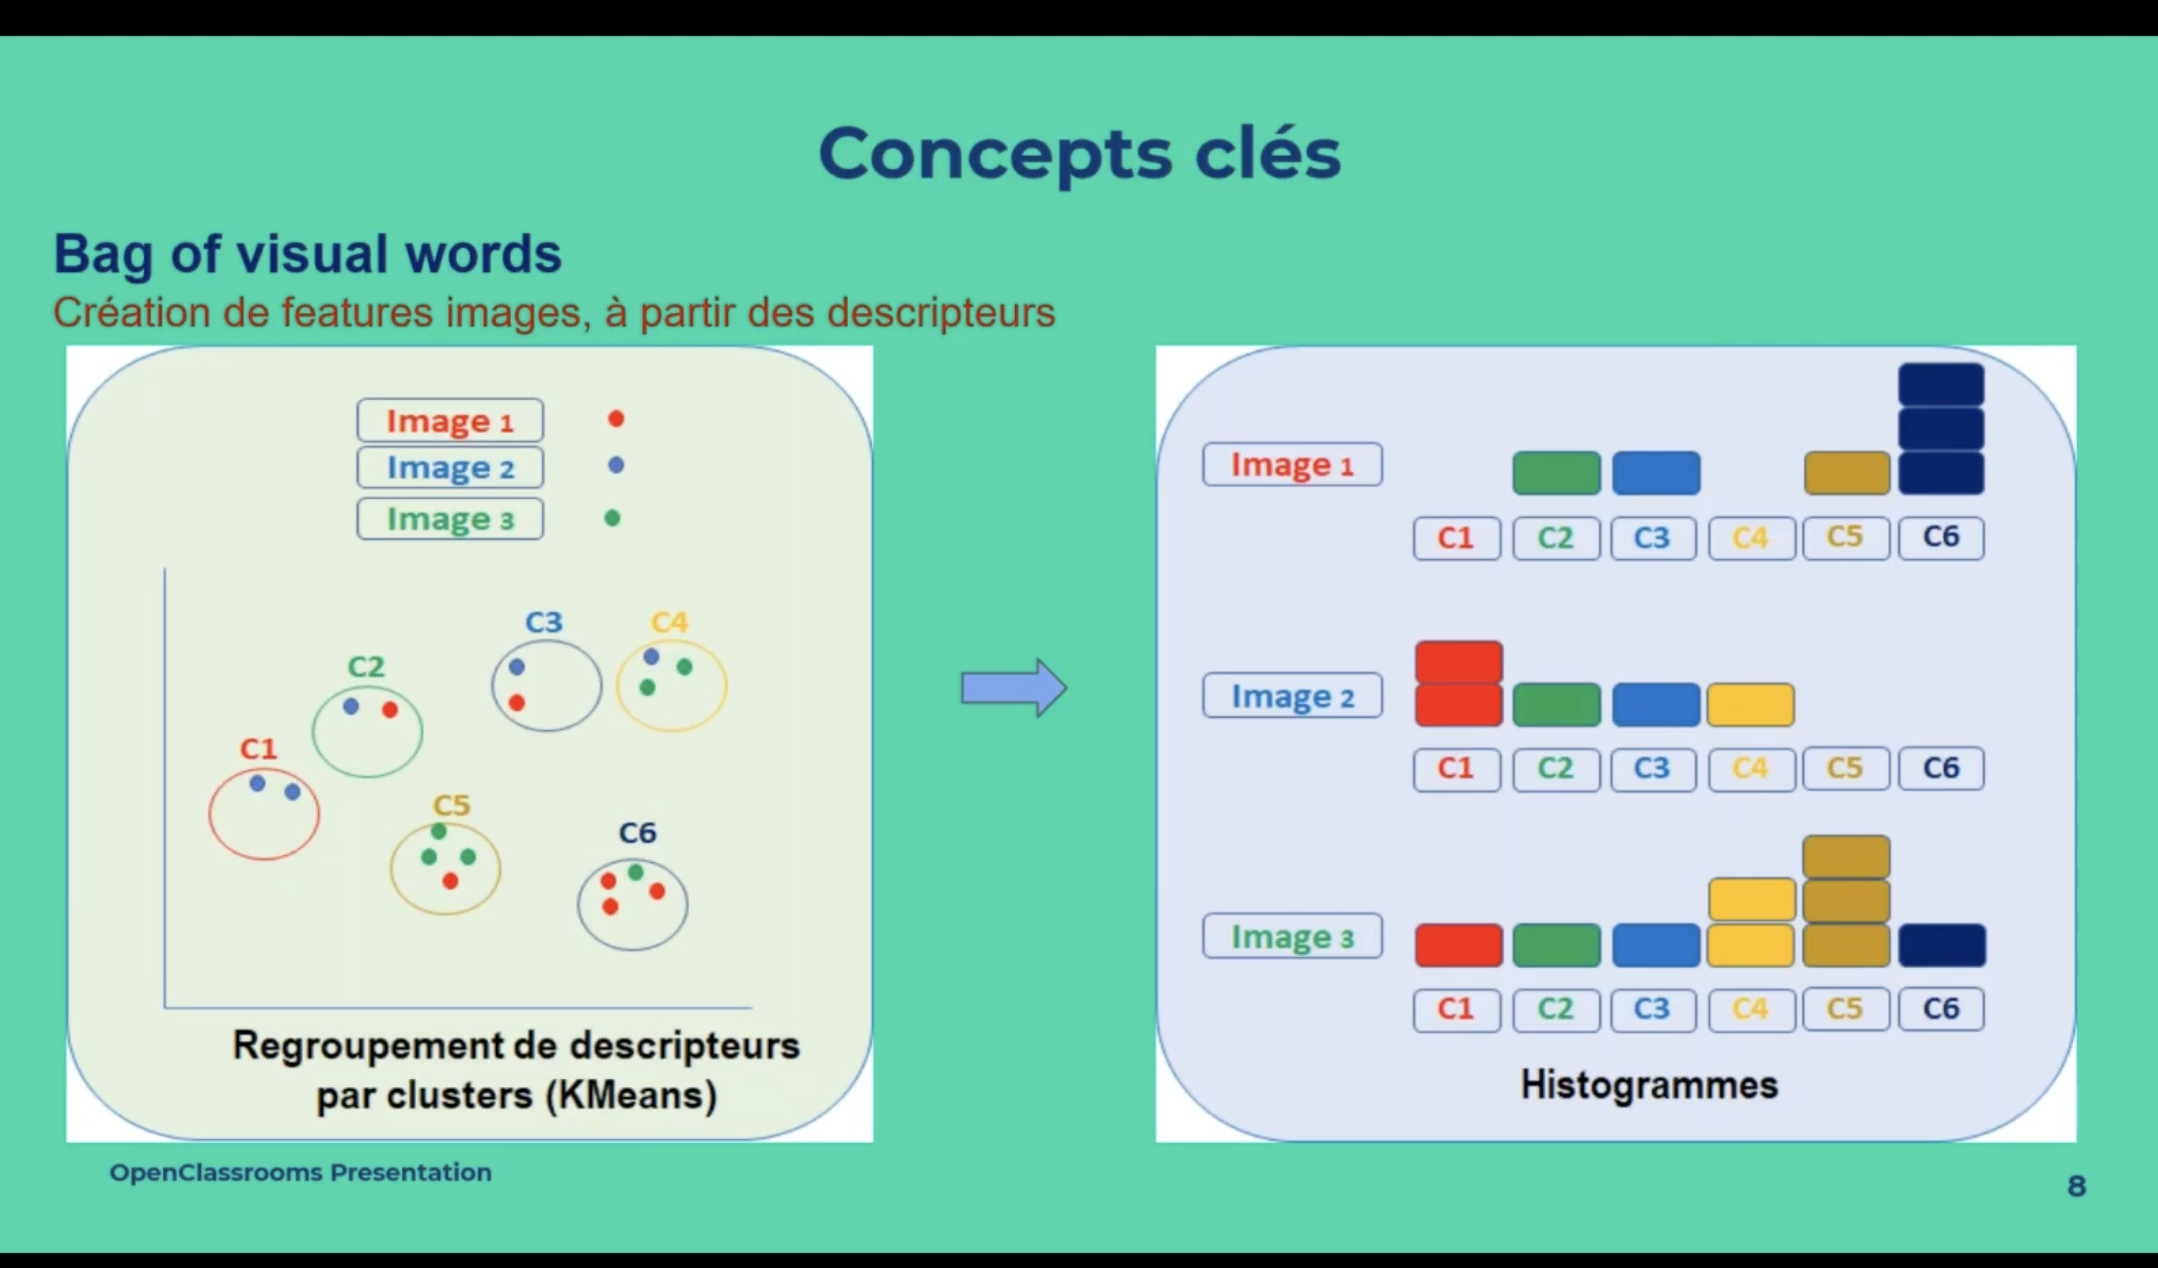

In [ ]:

display.Image("Capture d’écran 2024-01-30 à 13.36.39.png", width = 600)

In [ ]:
# puis bag of visual words
# -> regroupements en clusters de descripteurs qui sont proches entre eux avec kmeans ou équivalent puis on compte combien il y a de descripteurs par clusters et par image
# ici C1, C2, C3... = clusters

# démarche génnérale : 
# 1 - création de descripteurs par image et pour toutes les images
# 2 - création de clusters de descripteurs
# 3 - création d'histogramme par image
# 4 - réduction de dimension PCA / T-SNE
# 5 - analyse visuelle : affichage T-SNE selon catégories d'images
# 6 - analyses mesures : similarité entre catégories et clusters

In [ ]:
path = "../../data/Images/"
list_photos = [file for file in listdir(path)]
print(len(list_photos))

1051


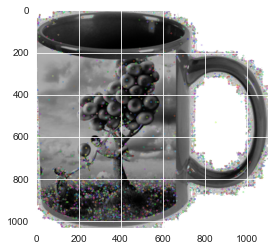

Descripteurs :  (3028, 128)

[[  0.   0.   0. ...  72.   6.   1.]
 [ 37.  14.   6. ...   0.   0.   0.]
 [ 97.  13.   9. ...   0.   0.   0.]
 ...
 [  5.  74.  31. ...   0.   0.   0.]
 [ 66.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ... 120.   4.   5.]]


In [ ]:
# Création des descripteurs pour une image (test)
sift = cv2.SIFT_create()
image = cv2.imread(path + list_photos[29], 0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img = cv2.drawKeypoints(image, kp, image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

In [ ]:
########## Création des descripteurs pour chaque image ##########
# identification of key points and associated descriptors
import time, cv2
sift_keypoints = []
temps1 = time.time()
sift = cv2.SIFT_create(500)

for image_num in range(len(list_photos)):
    try:
        image = cv2.imread(path + list_photos[image_num], 0) # convert in gray
        res = cv2.equalizeHist(image) # equalize image histogram
        kp, des = sift.detectAndCompute(res, None)
        sift_keypoints.append(des)
    except:
        print(image_num)

sift_keypoints_by_img = np.asarray(sift_keypoints, dtype = 'object')
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis = 0)

print('Nombre de descripteurs : ', sift_keypoints_all.shape)

duration1 = time.time() - temps1
print('temps de traitement SIFT descriptor : ', '%15.2f' % duration1, 'secondes')

140
Nombre de descripteurs :  (517351, 128)
temps de traitement SIFT descriptor :           257.16 secondes


In [ ]:
# tuner paramètres -> choix nb de descripteurs

In [ ]:
# Création des clusters de descripteurs

# Determination number of clusters
temps1 = time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)), 0))
print("Nombre de clusters estimés : ", k)
print("Création de", k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters = k, init_size = 3*k, random_state = 0)
kmeans.fit(sift_keypoints_all)

duration1 = time.time() - temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...
temps de traitement kmeans :             5.71 secondes


In [ ]:
# Création des features des images
# Creation of histograms (features)
temps1 = time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des == 0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors = []

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1 = time.time() - temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             1.64 secondes


In [ ]:
# Réduction de dimension - PCA

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components = 0.99)
feat_pca = pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 719)
Dimensions dataset après réduction PCA :  (1050, 499)


In [ ]:
data

label_name  \
0     Home and Kitchen Essential   
1         Baby and Personal Care   
2     Home and Kitchen Essential   
3     Home and Kitchen Essential   
4    Electronics and Accessories   
..                           ...   
896       Baby and Personal Care   
897       Baby and Personal Care   
898       Baby and Personal Care   
899       Baby and Personal Care   
900       Baby and Personal Care   

                                            image_path  label  
0    ../../data/Images/55b85ea15a1536d46b7190ad6fff...      3  
1    ../../data/Images/7b72c92c2f6c40268628ec5f14c6...      0  
2    ../../data/Images/d4684dcdc759dd9cdf41504698d7...      3  
3    ../../data/Images/6325b6870c54cd47be6ebfbffa62...      3  
4    ../../data/Images/f355cc1ccb08bd0d283ed979b7ee...      1  
..                                                 ...    ...  
896  ../../data/Images/38782cce965307ddcdbedfcb7fa4...      0  
897  ../../data/Images/be0f39341d771aac57084970f1ed...      0  
898  ../../data/Images/958f54f4c46b53c8a0a9b8167d91...      0  
899  ../../data/Images/c3edc504d1b4f0ba6224fa53a43a...      0  
900  ../../data/Images/f2f027ad6a6df617c9f125173da7...      0  

[901 rows x 3 columns]

In [ ]:
# Réduction de dimension - TSNE

tsne = manifold.TSNE(
    n_components = 2,
    perplexity = 30,
    n_iter = 2000,
    init = 'random',
    random_state = 6
    )
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns = ['tsne1', 'tsne2'])
df_tsne['class'] = data['label_name']
print(df_tsne.shape)

(1050, 3)


In [ ]:
sift_keypoints_by_img

array([array([[51.,  9.,  7., ...,  2.,  1., 57.],
              [11.,  1.,  0., ...,  0.,  0.,  9.],
              [21.,  0.,  0., ...,  1.,  0., 15.],
              ...,
              [48.,  2.,  0., ...,  2.,  0.,  0.],
              [43.,  3.,  0., ..., 15.,  1.,  0.],
              [25.,  2.,  0., ...,  1.,  1.,  1.]], dtype=float32),
       array([[ 29.,  27.,  11., ...,   4.,  26.,   3.],
              [ 35.,  50.,   4., ...,   0., 115., 112.],
              [  0.,   0.,  12., ...,   0.,   0.,   0.],
              ...,
              [ 37.,   1.,   0., ...,   0.,   0.,  50.],
              [ 25.,   1.,   1., ...,  17.,   3.,   4.],
              [  5.,   5.,   4., ...,   1.,   0.,   0.]], dtype=float32),
       array([[  0.,  16., 123., ...,   0.,   0.,   6.],
              [  0.,   9.,  50., ...,   0.,   0.,   1.],
              [  0.,   0.,   0., ...,   0.,   0.,   1.],
              ...,
              [  1.,   0.,   0., ...,  18.,   6.,  12.],
              [ 26.,   5.,  25., 

In [ ]:
# fin -> j'obtiens un vecteur qui va décrire mon image
# utiliser ces vecteurs pour classif
# faire classification puis comparer avec résultats cnn
# faire un kmeans
# faire visualisation des images en 2D (graph tsne)
# calculer un score (ARI score)

# normalement on devrait être amenés à dire que sift/orb/surf -> anciennes méthodes moins performantes vs CNN, cependant ici pas vraiment une différence

### CNN

In [ ]:
########## Convolutional Neural Network (CNN) ##########

# = réseaux de neurones convolutifs
# = modèles de programmation puissants permettant notamment la reconnaissance d’images en attribuant automatiquement à chaque image fournie en entrée, 
# une étiquette correspondant à sa classe d’appartenance

# Utilisation :
# réseaux convolutifs apprennent plus rapidement et ont un meilleur taux d’erreur. Dans une moindre mesure, on les utilise aussi pour l’analyse vidéo
# Ce type de réseau est aussi utilisé pour le traitement naturel du langage
# utilisation pour les logiciels de jeu de Go ou de jeu d'échecs

# Explication :
# Les CNN désignent une sous-catégorie de réseaux de neurones et sont à ce jour un des modèles de classification d’images réputés être les plus performant
# Leur mode de fonctionnement est à première vue simple : l’utilisateur fournit en entrée une image sous la forme d’une matrice de pixels
# Celle-ci dispose de 3 dimensions :
# - Deux dimensions pour une image en niveaux de gris.
# - Une troisième dimension, de profondeur 3 pour représenter les couleurs fondamentales (Rouge, Vert, Bleu).

# Contrairement à un modèle MLP (Multi Layers Perceptron) classique qui ne contient qu’une partie classification, l’architecture du Convolutional Neural Network 
# dispose en amont d’une partie convolutive et comporte par conséquent deux parties bien distinctes :
# -- Une partie convolutive :
#       Son objectif final est d’extraire des caractéristiques propres à chaque image en les compressant de façon à réduire leur taille initiale.
#       En résumé, l’image fournie en entrée passe à travers une succession de filtres, créant par la même occasion de nouvelles images appelées cartes de convolutions. 
#       Enfin, les cartes de convolutions obtenues sont concaténées dans un vecteur de caractéristiques appelé code CNN.
# -- Une partie classification :
#       Le code CNN obtenu en sortie de la partie convolutive est fourni en entrée dans une deuxième partie, constituée de couches entièrement connectées appelées
#       perceptron multicouche (MLP pour Multi Layers Perceptron). Le rôle de cette partie est de combiner les caractéristiques du code CNN afin de classer l’image.

# https://datascientest.com/convolutional-neural-network#:~:text=Les%20CNN%20d%C3%A9signent%20une%20sous,d'une%20matrice%20de%20pixels.

#display.Image('General-structure-of-CNN-for-image-classification.ppm', width = 600)

(1162, 687, 3)


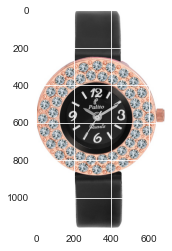

In [ ]:
# split en train / test

# Load an image train
img = load_img('../../data/Images/009099b1f6e1e8f893ec29a7023153c4.jpg')
x = img_to_array(img)  # this is a Numpy array with shape (260, 400, 1)
print(x.shape)
#x = x.reshape((x.shape[:2])) # this is a Numpy array with shape (260, 400)

# Display it
plt.figure()
plt.imshow(x/255., cmap = 'gray')
plt.show()

In [ ]:
# lister images dans data
liste_images = data['image_path'].to_list()
liste_images = [char.replace('../../data/Images/', '') for char in liste_images]
liste_images

['55b85ea15a1536d46b7190ad6fff8ce7.jpg',
 '7b72c92c2f6c40268628ec5f14c6d590.jpg',
 'd4684dcdc759dd9cdf41504698d737d8.jpg',
 '6325b6870c54cd47be6ebfbffa620ec7.jpg',
 'f355cc1ccb08bd0d283ed979b7ee7515.jpg',
 'dd0e3470a7e6ed76fd69c2da27721041.jpg',
 '920154acbe49d3202ed7d2ed2df1ea13.jpg',
 '1e8741b5ae27a513546c94b3f3312aee.jpg',
 '189fa66a5fa6f08d2802a62ecf0be298.jpg',
 'bbb8cdc5406ff60ff06ff64630f2ca47.jpg',
 '1120bc768623572513df956172ffefeb.jpg',
 '5479bb7028827d60000720a2c135976a.jpg',
 '733aa1e801a139fa8dc7be9f0eff5ee0.jpg',
 '62c35de4df27437d3597963fac55a8b6.jpg',
 '33d97d63c037078cd3f08033966d6a88.jpg',
 'd7ca2b06b4f4d3b98c61c377b18a2d6b.jpg',
 'f74476ba64365d97a5be7d375cbf4c7a.jpg',
 'fda50982a672ef8835de5c1cc86f8bfc.jpg',
 '4788f5466992da09024b8ffcc8a5cba4.jpg',
 '653826cd53f1d9e2c086c0ac7846ef70.jpg',
 '4aa047f14885c74f155ce5f973e14dff.jpg',
 '7c4fec2331da8d40f2cb146eb198cb57.jpg',
 'b52073e7ed9c00c4108cae4eb0c49c1a.jpg',
 'ee8d9ff65e0fe4278afce7c933d30941.jpg',
 '788dc3a3da91c0

In [ ]:
globbed = glob('../../data/Images/*.jpg')
globbed = [char.replace('../../data/Images/', '') for char in globbed]
globbed

['aa68675f50a0551b8dadb954017a50a1.jpg',
 '037c2402fee39fbc80433935711d1383.jpg',
 '42643c1c9403f67921a18654bcf45ead.jpg',
 '53f4bc7d7321f5c41de6b86e41f13e80.jpg',
 'b144a363c107c7bdd91f32d6e28ba6f2.jpg',
 'db3e2eeb4fe90d4755f2911d661eae95.jpg',
 '9a9402ad55d079c86c302521816b7b0e.jpg',
 '42a8fef62716772c391fbdd148cc9c16.jpg',
 '503bb08f7bdf6a395ec564dd1dc83619.jpg',
 '42770faa04bfcf2b62e7ef335e1b1965.jpg',
 '9c4ab8ab059c912090c83cb0818e7f1c.jpg',
 'f2fa99bfaa4aa65a2bd53337e140f949.jpg',
 'a618354ba17cff64826558d81afc77ab.jpg',
 'c063d07d78a55a21bf6c0e7c8ae46a6d.jpg',
 'e99d9abb115a9bd580bcccf9ff4d4881.jpg',
 '1d829e0eac91d7e85cdd6d581c363360.jpg',
 '5c7b493625b5fc6689cae49d25e1ae17.jpg',
 '06749cbff1487f470438823f6952cfd1.jpg',
 'ab3f4b2d2ec007b7e0eaec213bfdbffc.jpg',
 '473b1ab1abe21826c41efa1584a88a63.jpg',
 '07912328f580cf080d721e6466287896.jpg',
 'e47b9f88b773b3fd97ab3b51642ff6fb.jpg',
 '5cd3d274d71e1e0d6bf075421461b2d5.jpg',
 '7264f56639c8c54158b94ced769082c8.jpg',
 '0991e8d8f88400

In [ ]:
import os, shutil
path = '/Users/lucilerabeau/code/LucileRb/classification_auto_consommation/data/Images/'
moveto = '/Users/lucilerabeau/code/LucileRb/classification_auto_consommation/data/'
files = os.listdir(path)
files.sort()
for f in globbed:
    if f not in liste_images:
        print(f)
        src = path+f
        dst = moveto+f
        shutil.move(src,dst)

aa68675f50a0551b8dadb954017a50a1.jpg
53f4bc7d7321f5c41de6b86e41f13e80.jpg
9c4ab8ab059c912090c83cb0818e7f1c.jpg
40829ac110f344ef35f1c8c32fb311c7.jpg
b6c339777814451815fe7950fd4c8536.jpg
9a8fa4fd6524ada03411b033a9daadc1.jpg
fb733e04ff2d72c59d8513eb574e81a2.jpg
55195de3873fffaa9e37b041533d7305.jpg
86a39f77de21aa9654e8ea03335244fc.jpg
f4d4c2eec77732f56e47722d7a355f2b.jpg
85fe188e1ee8237b70df0d475907bf24.jpg
e39177ad1acf95e44ddd430bf969a86b.jpg
f3dec6a97225941bf9c3213e73943bd3.jpg
c3e1435782c0929327449eec11475b96.jpg
285075cfac3036e8d51591dfe5ba24ab.jpg
caabe6014b914fe2874a9a8d7284f79b.jpg
6ed4eb71c0707f1d6fdddcf62562cb02.jpg
ca82e1f23bb6cac66a32fce1c22534a3.jpg
a51b2c34b3d5a6e5d0591ee6e0b4d335.jpg
e3e7c584f317d1b5d6ac0088c411565e.jpg
bd95002e0fea67f7ec2f2597814c5eaf.jpg
27175ea71cc5f2879882c77b9931cf8b.jpg
8b268c1e68f198ae2e934717d49f48e9.jpg
bcb8e456728013a90ba66ab3b1b783ad.jpg
52877a6306aef18af67ab54c8233c931.jpg
e488005c7fb68747d3458c7d73760bae.jpg
f01140c02fd09e5c56312a64fa8db3da.jpg
7

In [ ]:
globbed2 = glob('../../data/Images/*.jpg')
globbed2

['../../data/Images/037c2402fee39fbc80433935711d1383.jpg',
 '../../data/Images/42643c1c9403f67921a18654bcf45ead.jpg',
 '../../data/Images/b144a363c107c7bdd91f32d6e28ba6f2.jpg',
 '../../data/Images/db3e2eeb4fe90d4755f2911d661eae95.jpg',
 '../../data/Images/9a9402ad55d079c86c302521816b7b0e.jpg',
 '../../data/Images/42a8fef62716772c391fbdd148cc9c16.jpg',
 '../../data/Images/503bb08f7bdf6a395ec564dd1dc83619.jpg',
 '../../data/Images/42770faa04bfcf2b62e7ef335e1b1965.jpg',
 '../../data/Images/f2fa99bfaa4aa65a2bd53337e140f949.jpg',
 '../../data/Images/a618354ba17cff64826558d81afc77ab.jpg',
 '../../data/Images/c063d07d78a55a21bf6c0e7c8ae46a6d.jpg',
 '../../data/Images/e99d9abb115a9bd580bcccf9ff4d4881.jpg',
 '../../data/Images/1d829e0eac91d7e85cdd6d581c363360.jpg',
 '../../data/Images/5c7b493625b5fc6689cae49d25e1ae17.jpg',
 '../../data/Images/06749cbff1487f470438823f6952cfd1.jpg',
 '../../data/Images/ab3f4b2d2ec007b7e0eaec213bfdbffc.jpg',
 '../../data/Images/473b1ab1abe21826c41efa1584a88a63.jpg

In [ ]:
len(globbed2)

901

In [ ]:
def plot_images(number_of_images, globbed2):
    shapes = []
    plt.figure(figsize = (13, 13))
    for i in range(number_of_images):
        plt.subplot(5, 5, i+1)
        image = imread(globbed2[random.randint(0, len(globbed2)-1)])
        plt.imshow(image)
        shapes.append(image.shape)
    plt.show()
    return shapes

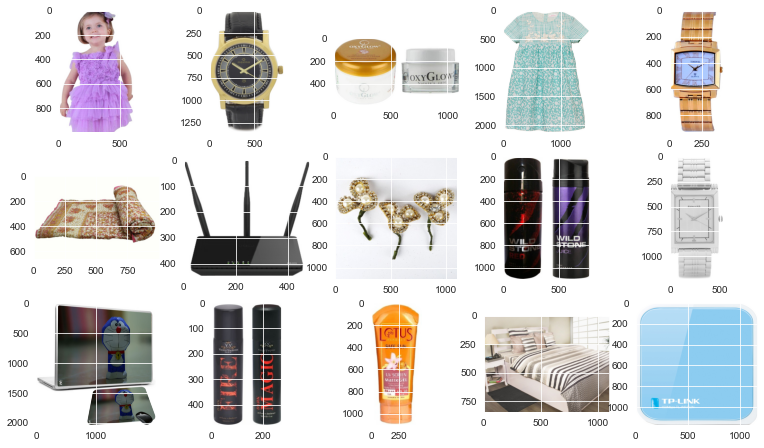

[(1000, 612, 3),
 (1360, 816, 3),
 (585, 1100, 3),
 (2130, 1502, 3),
 (930, 409, 3),
 (667, 1000, 3),
 (446, 482, 3),
 (1100, 1100, 3),
 (1100, 778, 3),
 (1225, 529, 3),
 (2033, 1994, 3),
 (480, 272, 3),
 (1100, 459, 3),
 (848, 1100, 3),
 (1173, 1170, 3)]

In [ ]:
plot_images(15, globbed2)

In [ ]:
data['label_name'].unique()

array(['Home and Kitchen Essential', 'Baby and Personal Care',
       'Electronics and Accessories', 'Festive and Special Occasion'],
      dtype=object)

In [ ]:
data

label_name  \
0     Home and Kitchen Essential   
1         Baby and Personal Care   
2     Home and Kitchen Essential   
3     Home and Kitchen Essential   
4    Electronics and Accessories   
..                           ...   
896       Baby and Personal Care   
897       Baby and Personal Care   
898       Baby and Personal Care   
899       Baby and Personal Care   
900       Baby and Personal Care   

                                            image_path  label  
0    ../../data/Images/55b85ea15a1536d46b7190ad6fff...      3  
1    ../../data/Images/7b72c92c2f6c40268628ec5f14c6...      0  
2    ../../data/Images/d4684dcdc759dd9cdf41504698d7...      3  
3    ../../data/Images/6325b6870c54cd47be6ebfbffa62...      3  
4    ../../data/Images/f355cc1ccb08bd0d283ed979b7ee...      1  
..                                                 ...    ...  
896  ../../data/Images/38782cce965307ddcdbedfcb7fa4...      0  
897  ../../data/Images/be0f39341d771aac57084970f1ed...      0  
898  ../../data/Images/958f54f4c46b53c8a0a9b8167d91...      0  
899  ../../data/Images/c3edc504d1b4f0ba6224fa53a43a...      0  
900  ../../data/Images/f2f027ad6a6df617c9f125173da7...      0  

[901 rows x 3 columns]

In [ ]:
# split en train / test

# split train dataset into train, validation and test sets
X_train, X_text, y_train, y_test = train_test_split(sift_keypoints_by_img, data['label'], random_state = 0, test_size = 0.3)
X_val, X_text, y_val, y_test = train_test_split(X_text, y_test, random_state = 0, test_size = 0.5)

ValueError: Found input variables with inconsistent numbers of samples: [1050, 901]

In [ ]:
X_train[0]

NameError: name 'X_train' is not defined

In [ ]:
X_train.shape

In [ ]:
# Is the train dataset unbalanced  ?
plt.figure(figsize = (20, 5))
sns.countplot(y_train)
plt.title('Repartition of label in the train dataset', fontweight = 'bold', fontstyle = 'italic', fontsize = 15)
plt.grid(which = 'major', color = '#DDDDDD', linewidth = 0.8)
plt.grid(which = 'minor', color = '#EEEEEE', linestyle = ':', linewidth = 0.5)
plt.tight_layout()
plt.show()

In [ ]:
X_text

In [ ]:
# use data generator to train the CNN
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    horizontal_flip = True,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    fill_mode = 'nearest'
    )

X_test = X_text/255

# transforming the labels (dummyfying) -> pas besoin vu que j'ai déjà fait ça manuellement avec le dictionnaire des catégories
#y_train = tf.keras.utils.to_categorical(y_train)
#y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
# CNN building
model = Sequential()

model.add(Conv2D(filters = 256, kernel_size = (5, 5), padding = 'same', activation = 'relu', input_shape = (28, 28, 1)))
model.add(MaxPooling2D())
model.add(Conv2D(filters = 128, kernel_size = (5, 5), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'same', activation = 'relu'))
model.add(Flatten())
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(24, activation = 'softmax'))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer = 'adam', metrics = ['accuracy'], loss = 'categorical_crossentropy')

In [ ]:
model.fit(train_datagen.flow(X_train, y_train, batch_size = 300), validation_data = (X_test, y_test), epochs = 40)

In [ ]:
y_pred = model.predict(X_test)

y_pred2 = np.array([np.argmax(y_pred[i]) for i in range(len(y_pred))])
y_test2 = np.array([np.argmax(y_test[i]) for i in range(len(y_test))])

In [ ]:
# Matrice de confusion
plt.figure(figsize = (15, 15))
sns.heatmap(confusion_matrix(y_test2, y_pred2), annot = True, cbar = False, cmap = 'Blues', annot_kws = {'size' : 8})
plt.xlabel('Predicted', fontdict = {'size': 20})
plt.ylabel('True', fontdict = {'size': 20})
plt.title('Confusion Matrix', fontdict = {'size': 20,'color':'Blue'})
plt.show()

In [ ]:
plt.figure(figsize = (15, 15))
for i in range(10):
    ind = np.random.randint(0, len(X_test))
    plt.subplot(5, 2, i+1)
    plt.imshow(X_test[ind].reshape(28,28), cmap = 'gray')
    plt.title('True : {} , Predicted : {} with {} % of probabilities '.format(category_mapping[y_test2[ind]], category_mapping[y_pred2[ind]], round(y_pred[ind][y_pred2[ind]]*100, 2)))
plt.show()

In [ ]:
# faire aussi TSNE, score ARI etc... même démarche que pour sift
# ne pas entrainer le modèle, prendre le modèle pré entrainé et seulement utiliser ça et faire ma feature extraction

# et ensuite -> partie classification supervisée sur images 
# en ouverture/ conclusion dire que pertinence de ma classification supervisée pourrait être améliorée en ajoutant données textes

# Etape 1 : étude de faisabilité

In [ ]:
## Création du modèle pré-entraîné

# Modèle VGG16
# pourquoi ? on fait quoi ici ?? expliquer un peu

base_model = VGG16()
model = Model(inputs = base_model.inputs, outputs = base_model.layers[-2].output)

print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
## Création des features des images

images_features = []
i = 0 
for image_file in data['image_path']:
    if i % 100 == 0:
        print(i)
    i +=1
    image = load_img(image_file, target_size = (224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis = 0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose = 0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0


2024-03-11 11:58:16.610565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100
200
300
400
500
600
700
800
900


(904, 4096)

## Réduction dimension et analyse

In [ ]:
### Réduction de dimension PCA

print(images_features.shape)
pca = decomposition.PCA(n_components = 0.99)
feat_pca = pca.fit_transform(images_features)
print(feat_pca.shape)

(904, 4096)
(904, 701)


In [ ]:
### Réduction de dimension T-SNE et affichage des images selon vraies classes

temps1 = time.time()

tsne = manifold.TSNE(n_components = 2, perplexity = 30, n_iter = 2000, init = 'random', random_state = 6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time() - temps1
print('temps de T-SNE : ', '%15.2f' % duration1, 'secondes')

temps de T-SNE :             3.78 secondes


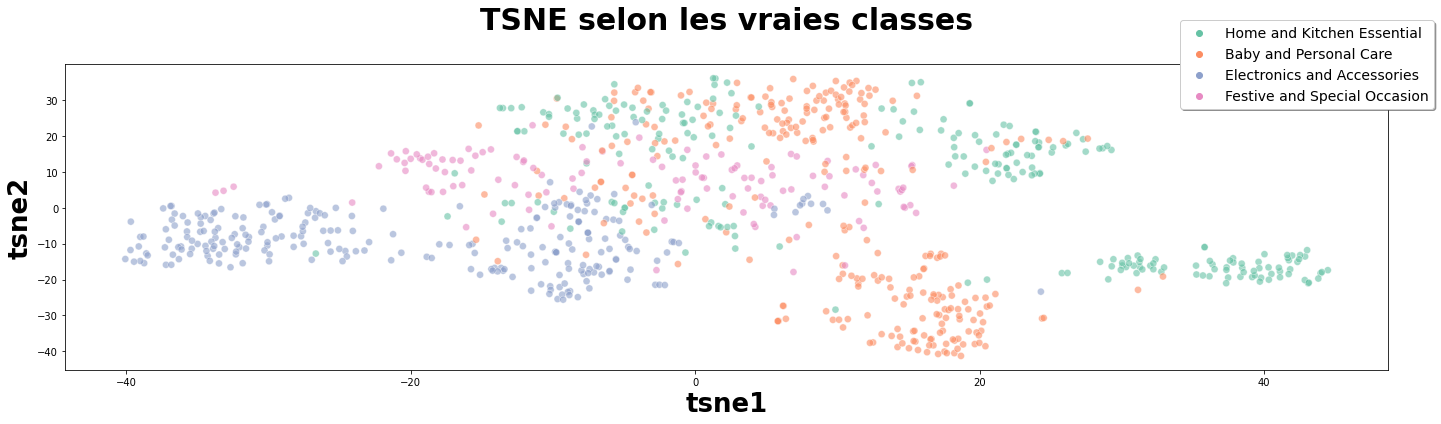

In [ ]:
df_tsne = pd.DataFrame(X_tsne, columns = ['tsne1', 'tsne2'])
df_tsne['class'] = data['label_name']

plt.figure(figsize = (20, 6))
sns.scatterplot(
    x = 'tsne1',
    y = 'tsne2',
    hue = 'class',
    s = 50,
    alpha = 0.6,
    data = df_tsne,
    legend = 'brief'
    )

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(loc = 'center right', prop = {'size': 14}, shadow = True, fancybox = True, bbox_to_anchor = (1.04, 1))
plt.tight_layout()
plt.show()

In [ ]:
### Création de clusters à partir du T-SNE et affichage des images selon clusters

cls = cluster.KMeans(n_clusters = 4, n_init = 100)
cls.fit(X_tsne)

KMeans(n_clusters=4, n_init=100)

In [ ]:
df_tsne['cluster'] = cls.labels_
df_tsne

tsne1      tsne2                        class  cluster
0    21.332956  12.114680   Home and Kitchen Essential        1
1    -9.718942  30.427195       Baby and Personal Care        1
2    19.678774  20.216387   Home and Kitchen Essential        1
3    23.970533  21.130463   Home and Kitchen Essential        1
4   -32.287270 -12.973014  Electronics and Accessories        3
..         ...        ...                          ...      ...
899  15.292920  10.547708       Baby and Personal Care        1
900  11.975715  11.140452       Baby and Personal Care        1
901  20.440649  12.766883       Baby and Personal Care        1
902   9.162046  12.195155       Baby and Personal Care        1
903  10.626367  10.273602       Baby and Personal Care        1

[904 rows x 4 columns]

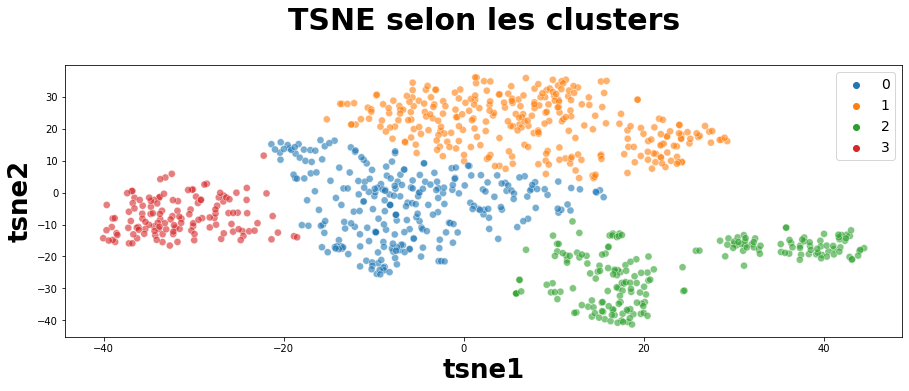

In [ ]:
# Visualisation du TSNE selon les clusters définis

plt.figure(figsize = (15, 5))
sns.scatterplot(
    x = 'tsne1',
    y = 'tsne2',
    hue = 'cluster',
    palette = sns.color_palette('tab10', n_colors = 4),
    s = 50,
    alpha = 0.6,
    data = df_tsne,
    legend = 'brief'
    )

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop = {'size': 14}) 
plt.show()

In [ ]:
# Calcul de l'ARI score

labels = data['label']
print('ARI : ', metrics.adjusted_rand_score(labels, cls.labels_))

ARI :  0.22270214327389096


In [ ]:
# Commenter l'ari score

In [ ]:
data.columns

Index(['label_name', 'image_path', 'label'], dtype='object')

tsne1                       -37.272861
tsne2                       -11.033908
class      Electronics and Accessories
cluster                              3
Name: 220, dtype: object


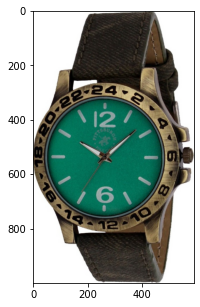

In [ ]:
# Affichage image
id = 220
print(df_tsne.iloc[id])
fig = plt.figure(figsize = (8, 5))
filename = data['image_path'][id]
image = imread(filename)
plt.imshow(image)
plt.show()

### Analyse par classes

In [ ]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[ 33 130 119   0]
 [124   2   1 127]
 [ 75  39   2   5]
 [ 35 131  80   1]]


In [ ]:
cls_labels_transform = data_preparation.conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)

Correspondance des clusters :  [1 3 0 1]
[[119  33   0 130]
 [  1 251   0   2]
 [  2  80   0  39]
 [ 80  36   0 131]]


In [ ]:
print(metrics.classification_report(labels, cls_labels_transform))

              precision    recall  f1-score   support

           0       0.59      0.42      0.49       282
           1       0.63      0.99      0.77       254
           2       0.00      0.00      0.00       121
           3       0.43      0.53      0.48       247

    accuracy                           0.55       904
   macro avg       0.41      0.49      0.43       904
weighted avg       0.48      0.55      0.50       904



In [ ]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels], columns = [i for i in '0123'])
df_cm

0    1  2    3
Home and Kitchen Essential    119   33  0  130
Baby and Personal Care          1  251  0    2
Electronics and Accessories     2   80  0   39
Festive and Special Occasion   80   36  0  131

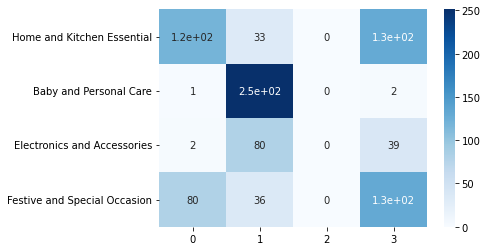

In [ ]:
# modifier format annotations
plt.figure(figsize = (6, 4))
sns.heatmap(df_cm, annot = True, cmap = 'Blues')
plt.show()

In [ ]:
# Exporter données (format pickle)

# Export données 'propres' au format pickle

# Chemin d'accès aux données (à modifier si code en local)
#path = '/content/drive/MyDrive/OpenClassrooms/Projet5/' #-> pour colab
path = '' #-> en local

# specifier le chemin choisi
filepath = os.path.join(path, '../../data/data')

# exporter en format pickle
with open(filepath, 'wb') as f:
    pickle.dump(data, f)

In [ ]:
# specifier le chemin choisi
filepath = os.path.join(path, '../../data/df_image')

# exporter en format pickle
with open(filepath, 'wb') as f:
    pickle.dump(df_image, f)

In [ ]:
# specifier le chemin choisi
filepath = os.path.join(path, '../../data/df_nan')

# exporter en format pickle
with open(filepath, 'wb') as f:
    pickle.dump(df_nan, f)

In [ ]:
# jeu de données complet avec nan
# specifier le chemin choisi
filepath = os.path.join(path, '../../data/df')

# exporter en format pickle
with open(filepath, 'wb') as f:
    pickle.dump(df, f)